# PRÁCTICA ML - JONÁS DE MARTÍN RODRÍGUEZ
### Modelo Supervizado de Clasificacón Múltiple - Bómbas de Agua

In [43]:
# Instalo las librerías necesarias en el entorno.
!pip install category_encoders
!pip install lightgbm
!pip install xgboost

In [44]:
# 1. Cargo las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
import lightgbm as lgb
import xgboost as xgb
from pandas import to_datetime
import time
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from category_encoders import OrdinalEncoder
from sklearn.cluster import KMeans
from google.colab import files
from imblearn.over_sampling import SMOTE
import pickle
import os
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [45]:
# 2. Cargo y leo los datos (CSV).
train_values = pd.read_csv("Training_set_values.csv")
train_labels = pd.read_csv("Training_set_labels.csv")
test_values = pd.read_csv("Test_set_values.csv")
submission_format = pd.read_csv("SubmissionFormat.csv")

In [46]:
# 3. Hago el Merge por la columna id
df_train = pd.merge(train_values, train_labels, on='id')

# Al hacer el merge, estoy juntando en un solo DataFrame (df_train).
# id es la clave única, que identifica cada punto de agua, y es común en ambos datasets.
# Hago un INNER JOIN - solo se conservan las filas, donde el id existe tanto en train_values como en train_labels.

# PREPROCESADO DE DATOS.
## 1. Análisis de los Datos.

In [47]:
# 1. Muestro las dimensiones de los datasets.
print("Tamaño del set de entrenamiento (valores + etiquetas):", df_train.shape)
print("Tamaño del set de test:", test_values.shape)

Tamaño del set de entrenamiento (valores + etiquetas): (59400, 41)
Tamaño del set de test: (14850, 40)


In [48]:
# 2. Veo la distribución de la variable objetivo - 'status_group'.
print("\nDistribución de clases en 'status_group':")
print(df_train['status_group'].value_counts())


Distribución de clases en 'status_group':
status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64


In [49]:
# 3. Muestro las dimensiones del dataset final de entrenamiento.
print("Dataset de entrenamiento con etiquetas:")
print(df_train.shape)

Dataset de entrenamiento con etiquetas:
(59400, 41)


In [50]:
# 4. Muestro las primeras filas para verificar el dataset.
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [51]:
# 5. Saco un resumen rápido de la estructura del DataFrame.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [52]:
# 6. Saco el tipo de dato de cada columna.
df_train.dtypes

,0
id,int64
amount_tsh,float64
date_recorded,object
funder,object
gps_height,int64
installer,object
longitude,float64
latitude,float64
wpt_name,object
num_private,int64


In [53]:
# 7. Saco un resumen estadístico de todas las columnas numéricas.
df_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## 2. Detección de valores nulos - sin imputar

In [54]:
# 1. Saco los valores nulos (NaN) que hay en cada columna.
df_train.isnull().sum()

,0
id,0
amount_tsh,0
date_recorded,0
funder,3637
gps_height,0
installer,3655
longitude,0
latitude,0
wpt_name,2
num_private,0


In [55]:
# 2. Saco la media de los valores nulos (NaN) que hay en cada columna.
df_train.isnull().mean()

,0
id,0.000000
amount_tsh,0.000000
date_recorded,0.000000
funder,0.061229
gps_height,0.000000
installer,0.061532
longitude,0.000000
latitude,0.000000
wpt_name,0.000034
num_private,0.000000


In [56]:
# en la variable scheme_name tenemos el 48% de nulos - por lo que es la variable con más nulos.
# cinco variables tienen un porcentaje pequeño sobre el 5% y dos muy pequeño 0.5% de nulos.

## 2.1. Cardinalidad

In [57]:
# 3. Calculo la cardinalidad, para saber cuántos valores únicos tiene la variable 'scheme_name' ya que tiene un 48% de nulos.
# Lo hago para decidir qué hacer con esa columna durante el preprocesamiento, antes de modelar.

num_unique_scheme_names = df_train['scheme_name'].nunique()
print(f"Valores únicos en 'scheme_name': {num_unique_scheme_names}")

# Ver la proporción de valores únicos respecto al total.
total_rows = df_train.shape[0]
proporcion_unicos = num_unique_scheme_names / total_rows
print(f"\nProporción de valores únicos: {proporcion_unicos:.2%}")

# Esta variable tiene una alta cardinalidad, lo que puede causar overfitting, ruido y baja generalización.

Valores únicos en 'scheme_name': 2695

Proporción de valores únicos: 4.54%


# PREPROCESADO Y ENTRENAMIENTO DEL MODELO.

In [58]:
# 1. Hago una transformación temporal de la fecha de registro (date_recorded) - Feature Engineering.
# Extraigo nuevas variables a partir de la fecha en que se registró el punto de agua.
# Esta transformación, permite capturar patrones temporales que podrían relacionarse con la calidad del registro,
# campañas de mantenimiento, épocas de instalación o deterioro del pozo, entre otros factores.

# Las nuevas variables extraídas son:
# - year_recorded: el año del registro (puede reflejar antigüedad del punto o el contexto temporal).
# - month_recorded: mes del registro (puede capturar estacionalidad en las instalaciones o fallos).
# - day_recorded: día del mes (puede reflejar errores sistemáticos de entrada o relevamiento).
# - weekday_recorded: día de la semana (útil si las inspecciones o mantenimientos siguen una rutina semanal).

# Aunque no son variables directamente técnicas del pozo, aportan contexto adicional que mejora la capacidad del modelo.
# En este caso, solo con estas transformaciones se alcanzó un score de validación de 0.8150.
for df in [df_train, test_values]:
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    df['weekday_recorded'] = df['date_recorded'].dt.weekday
    df.drop(columns=['date_recorded'], inplace=True)

In [ ]:
'''# 2. Creo una nueva variable binaria 'population' - feature engineering.
# Estamos ante una variable binaria: la cual indica, si la población es mayor a cero.
# Hago la Transformación logarítmica, para reducir el sesgo de valores extremos.
for df in [df_train, test_values]:
    df['has_population'] = df['population'].apply(lambda x: 0 if x == 0 else 1)
    df['log_population'] = df['population'].apply(lambda x: np.log1p(x))  # log(1 + x) para evitar log(0)
# has_population aporta presencia o ausencia, útil para modelos que distinguen entre "uso real" y "registro sin servicio".
# log_population permite aprovechar la magnitud real de la población, sin que los valores extremos distorsionen el entrenamiento del modelo.

In [ ]:
'''# 3. Creo una nueva variable antigüedad del punto de agua (well_age) - feature engineering.
# Entiendo que esta variable puede aportar información importante al modelo y mejoras el score.
# Esta característica representa cuántos años han pasado desde que el pozo fue construido,
# lo cual podría indicar el desgaste, deterioro o necesidad de mantenimiento.
# Es una transformación temporal común en problemas de predicción de fallos o funcionamiento.
# Para evitar perder registros, se imputan los valores 0 (años desconocidos) con la mediana.
for df in [df_train, test_values]:
    df['construction_year'] = df['construction_year'].replace(0, np.nan)
    mediana_construction = df['construction_year'].median()
    df['construction_year'] = df['construction_year'].fillna(mediana_construction)
    df['well_age'] = df['year_recorded'] - df['construction_year']

# Aunque la variable es relevante, en este modelo específicocon Random Forest no se observó una mejora en el score de validación (bajó ligeramente de 0.8150 a 0.8133).
# Aun así, se documenta como parte del análisis exploratorio y puede ser útil en otros modelos o con otros tratamientos.

In [59]:
# 4. Genero una nueva variable llamada 'is_motorized' que identifica si el punto de agua utiliza - feature engineering.
# un sistema de extracción motorizado, como 'motorpump', 'submersible', 'mono', entre otros.
# Esta variable permite distinguir, pozos que podrían requerir mayor mantenimiento,
# mayor inversión inicial, o depender de suministro eléctrico o combustible.
# Esto puede ser relevante, para predecir el estado funcional, ya que los sistemas motorizados,
# si bien suelen ser más eficientes, también pueden ser más susceptibles a fallos mecánicos o falta de mantenimiento.
# El valor será 1 si el punto utiliza extracción motorizada, y 0 en caso contrario.
# Esta variable indica si el punto de agua tiene un sistema de extracción motorizado.
motorized = ['motorpump', 'submersible', 'mono', 'other']

for df in [df_train, test_values]:
    df['is_motorized'] = df['extraction_type_class'].apply(lambda x: 1 if x in motorized else 0)


In [ ]:
'''# 5. Creo una nueva variable de agrupación geográfica (geo_cluster) mediante KMeans - feature engineering.
# Agrupo los puntos de agua en 15 regiones distintas, basadas en su ubicación (latitude y longitude) usando el algoritmo de KMeans clustering.
# Esta nueva variable puede capturar información espacial relevante, como diferencias regionales en la infraestructura,
# mantenimiento o condiciones geográficas que podrían influir en el funcionamiento del punto de agua.
# Este enfoque permite introducir en el modelo una representación simplificada de la localización,
# sin necesidad de usar directamente latitud y longitud como variables continuas.
# Se aplica tanto al conjunto de entrenamiento (df_train), como al de test (test_values), para asegurar consistencia en la transformación.
# Se define el número de clusters a 15 como punto de partida.
N_CLUSTERS = 15
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

df_train['geo_cluster'] = kmeans.fit_predict(df_train[['latitude', 'longitude']])
test_values['geo_cluster'] = kmeans.predict(test_values[['latitude', 'longitude']])
# Aunque esperaba que esta variable aportara valor al capturar patrones regionales, no se observó una mejora significativa del score,
# en este modelo específico con Random Forest (pasó de 0.8150 a 0.8147).

### Durante el proceso de mejora del modelo Random Forest para la predicción del estado funcional de puntos de agua en Tanzania, he aplicado diversas transformaciones sobre el conjunto de datos original, con el objetivo de enriquecer la información disponible para el modelo sin introducir ruido, ni redundancia. A continuación, describo las tres transformaciones con las que he logrado un mejor score, acompañadas de su justificación y del impacto observado en el score de evaluación en plataforma.

El mejor score que he logrado es de 0.8160.

1.   Fecha descompuesta en componentes temporales (year_recorded, month_recorded, day_recorded, weekday_recorded)

Descripción: descompuse la variable date_recorded en varias variables explícitas, cada una capturando diferentes aspectos temporales del registro.

Justificación: Las fechas pueden contener información latente sobre políticas de mantenimiento, estacionalidad en las fallas, o ciclos de inspección.

Impacto: Esta transformación por sí sola, logró un score de 0.8150, evidenciando su valor predictivo directo y su bajo riesgo de sobreajuste.

2.   Variable binaria is_motorized.

Descripción: Creo una nueva variable que identifica si el punto de agua utiliza un sistema de extracción motorizado (e.g., motorpump, submersible).

Justificación: Los sistemas motorizados, presentan características operativas distintas (mayor complejidad mecánica, dependencia energética) que influyen directamente en la probabilidad de fallo.

Impacto: en combinación con las variables temporales, esta nueva característica, logró el mejor score observado: 0.8160, indicando que es altamente relevante para el modelo.

3.   Varibles: fecha descompuesta en componentes temporales, geográficas (geo_cluster) usando KMeans y population.

Descripción: Creo has_population, que indica si hay al menos una persona beneficiaria del pozo. Y log_population, que aplica una escala logarítmica a la población para mitigar valores extremos.

Justificación: Las condiciones geográficas y regionales pueden tener un efecto directo sobre el estado funcional (acceso, clima, recursos, infraestructura).
La presencia y el tamaño de la población, influye en el mantenimiento y uso del punto de agua. Esta transformación permite modelar mejor estas diferencias.

Impacto: Combinadas con las variables de fecha, alcanzó un score de 0.8153, el segundo mejor rendimiento observado. Aunque no supera a is_motorized, aporta valor demográfico al modelo.

Conclusión final

El mejor rendimiento se alcanzó combinando variables temporales y el indicador is_motorized, lo que sugiere que tanto los factores temporales como las características técnicas del sistema de extracción, son los mayores determinantes, del estado operativo de un punto de agua.







##  Tratamiento de valores nulos.

In [60]:
# 1. Imputo con 'unknown' (texto) - feature engineering.
for col in ['funder', 'installer', 'scheme_management', 'subvillage', 'wpt_name']:
    df_train[col] = df_train[col].fillna('unknown')
    test_values[col] = test_values[col].fillna('unknown')
# Estrategia que decido emplear: sustituyo los valores nulos por el texto 'unknown', lo que permite.
# Conservar la fila en lugar de eliminarla.
# Indicar explícitamente que se desconoce ese dato.
# Evitar errores en codificación posterior (por ejemplo con OrdinalEncoder).

# 2. Imputo con la moda (valor más frecuente) - feature engineering
for col in ['public_meeting', 'permit']:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    test_values[col] = test_values[col].fillna(test_values[col].mode()[0])
# Estrategia que decido emplear: reemplazo los valores nulos, por el valor más frecuente de la columna (la moda),
# bajo la suposición de que el comportamiento más común, es una buena estimación.

# Imputo con la moda y no la media, ya que las variables son categóricas booleanas - No son variables numéricas continuas;
# por tanto, no tiene sentido calcular una media.

# 3. Elimino la columna con demasiados nulos o baja relevancia - feature engineering.
df_train.drop(columns=['scheme_name'], inplace=True, errors='ignore')
test_values.drop(columns=['scheme_name'], inplace=True, errors='ignore')
# Estrategia que decido emplear:
# la descarto directamente, ya que imputarla generaría ruido.
# Ya que codificarla, implicaría aumentar dimensionalidad sin garantía de beneficio.

<ipython-input-60-9ed49f64b8b6>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
<ipython-input-60-9ed49f64b8b6>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_values[col] = test_values[col].fillna(test_values[col].mode()[0])


In [61]:
# 4. Compruebo que no hay valores nulos en el dataset - feature engineering.

print("¿Quedan valores nulos después del tratamiento?")
print(df_train.isnull().sum().sort_values(ascending=False).head(50))

¿Quedan valores nulos después del tratamiento?
id                       0
amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_c

## Conversión a numéricas, las variables categóricas.

In [62]:
# 1. Identifico las columnas categóricas - feature engineering.
# cat_cols captura todas las columnas de tipo object.
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != 'status_group']

# 2. Codifico las variables predictoras categóricas - feature engineering.
encoder = OrdinalEncoder(cols=cat_cols, handle_unknown='impute', handle_missing='value')
df_train[cat_cols] = encoder.fit_transform(df_train[cat_cols])
test_values[cat_cols] = encoder.transform(test_values[cat_cols])

# 3. Codifico la variable objetivo (status_group) - feature engineering.
le = LabelEncoder() # Uso LabelEncoder para conviertir cada clase de la variable objetivo, en un número.
df_train['status_group_encoded'] = le.fit_transform(df_train['status_group'])

## Escalado de variables

In [63]:
# 1. Hago el escalado, para transformar las variables numéricas y estén en una escala similar - feature engineering.
# Aunque no es estríctamente necesario hacelo para algoritmos como Random Forest, XGBoost, LightGBM, pero a veces ayuda a la estabilidad.
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'status_group_encoded']]

# Creo un escalado tipo StandardScaler, que transforma los datos a: media = 0 - desviación estándar = 1 - feature engineering
scaler = StandardScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
test_values[numeric_cols] = scaler.transform(test_values[numeric_cols])

# Todas las variables numéricas, ahora tienen valores centrados en 0 y en la misma escala.
# Esto evitará que alguna variable con rangos altos, domine el modelo solo por su magnitud.

## División del conjunto de entrenamiento en entrenamiento y validación.

In [64]:
# 1. Divido el dataset en:
# X_train, y_train: para entrenar el modelo - feature engineering.
# X_test, y_test: para evaluar el rendimiento con datos nunca vistos - feature engineering.

X = df_train.drop(columns=['id', 'status_group', 'status_group_encoded']) # X contiene todas las variables predictoras (features).
y = df_train['status_group_encoded'] # y es la variable objetivo ya codificada como número.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X = df_train.drop(columns=['id', 'status_group', 'status_group_encoded'])
y = df_train['status_group_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ahora tendré un conjunto X_train / y_train para entrenar el modelo.
# y un conjunto X_test / y_test para evaluar su rendimiento.

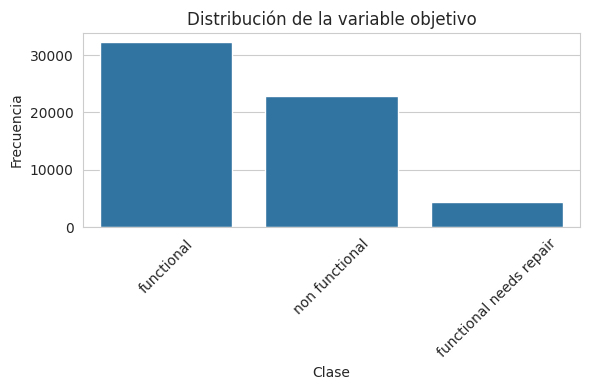

In [65]:
# 2. Hago las visualizacones exploratorias para analizar la estructura y calidad de los datos antes del modelado.
# 2.1. Muestro la distribución de la variable objetivo (status_group) - gráfico de barras, que indica cuántos ejemplos hay de cada clase objetivo.
plt.figure(figsize=(6,4))
sns.countplot(x=df_train['status_group'])
plt.title("Distribución de la variable objetivo")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# En La gráfica siguiente se muestra la distribución de la variable objetivo status_group, en el conjunto de entrenamiento.
# A partir de ella, se pueden sacar varias conclusiones importantes, sobre el balance de clases:
# - Clase más común: functional es la clase dominante, con más de 30,000 registros.
# - Clase intermedia: non functional está en frecuencia, con alrededor de 22,000 observaciones.
# - Clase minoritaria: functional needs repair, tiene una frecuencia muy baja, con menos de 5,000 registros.


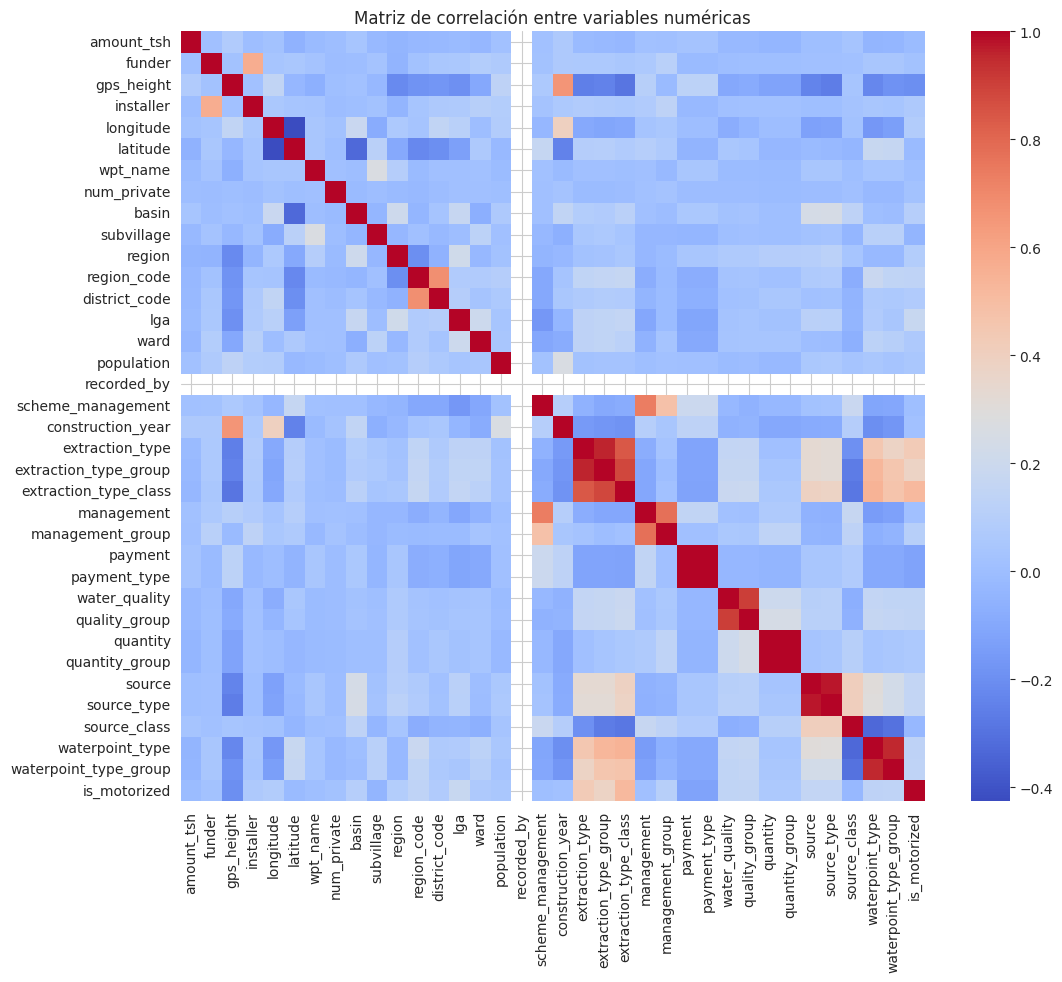

In [66]:
# 2.2. Hago la visualizacion de un mapa de calor de correlación, entre variables numéricas. Para visualizar la correlación lineal entre todas las variables numéricas.
# Para:
# - Detectar redundancias entre variables (muy correlacionadas entre sí).
# - Identificar patrones interesantes.
# - Decidir si eliminar o combinar variables similares.
plt.figure(figsize=(12, 10))
corr = df_train[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# La matriz de correlación mostrada en la siguiente gráfica, revela que varias variables están altamente correlacionadas (como tipos de extracción y cantidad),
# lo que sugiere posibles redundancias que podrían optimizarse para mejorar el modelo.

In [ ]:
'''# 3. Hago el balancieo de clases con SMOTE - feature engineering.
# Lo aplico sobre el conjunto de entrenamiento, para tratar de mejorar la representación de clases minoritarias.
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# SMOTE logró aumentar el recall de la clase minoritaria "functional needs repair" del 0.33 al 0.44, lo cual es positivo en cuanto a detección de esa clase.
# Sin embargo, el score general (accuracy) bajó ligeramente de 0.8141 a 0.8025, indicando que el balanceo introdujo cierta pérdida de precisión en las clases mayoritarias.
# Esto sugiere que el modelo ahora sería más sensible a detectar fallos intermedios, pero a costa de una leve caída global de rendimiento. Por lo que no los aplico.

## Modelado con Random Forest.

In [67]:
# 1. Entreno un modelo de Random Forest y realizo predicciones sobre el conjunto de validación.
# Random Forest es un algoritmo de ensamble de árboles de decisión. Crea muchos árboles y combina sus predicciones para mejorar la precisión y evitar overfitting.
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
# n_estimators=300: construye 300 árboles en el bosque.
# random_state=42: garantiza resultados reproducibles.
# n_jobs=-1: usa todos los núcleos del procesador para acelerar el entrenamiento.
rf_model.fit(X_train, y_train)
# Entrena el modelo con los datos de entrenamiento.
y_pred_rf = rf_model.predict(X_test)
# Hace predicciones sobre los datos de prueba (X_test).

In [68]:
# 2. Avaluo el rendimiento del modelo de Random Forest, usando métricas estándar de clasificación.
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf)) # Muestra el Accuracy (exactitud) del modelo.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
# Saca por pantalla un reporte detallado que incluye:
# Precision: qué proporción de las predicciones positivas fueron realmente positivas.
# Recall: qué proporción de los positivos reales fueron correctamente identificados.
# F1-score:	media armónica entre precision y recall (equilibrio entre ambas).
# Support: cantidad de muestras reales de cada clase.

Random Forest - Accuracy: 0.8141414141414142

Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.58      0.33      0.42       863
         non functional       0.85      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



### Al hacer el análisis del rendimiento del modelo Random Forest, se observa que la métrica de exactitud global alcanza un 81.41%, lo cual es consistente con modelos robustos aplicados a problemas multiclase en entornos reales. No obstante, una evaluación detallada del informe de clasificación revela un patrón importante: el modelo presenta un alto desempeño para las clases functional (F1 = 0.85) y non functional (F1 = 0.82), pero un rendimiento significativamente inferior para la clase functional needs repair (F1 = 0.42), con un recall particularmente bajo (0.33).
Conclusión:
El modelo Random Forest, logra una buena precisión general (81%), pero presenta dificultades para identificar correctamente la clase minoritaria functional needs repair, lo que sugiere un problema de desbalance de clases.

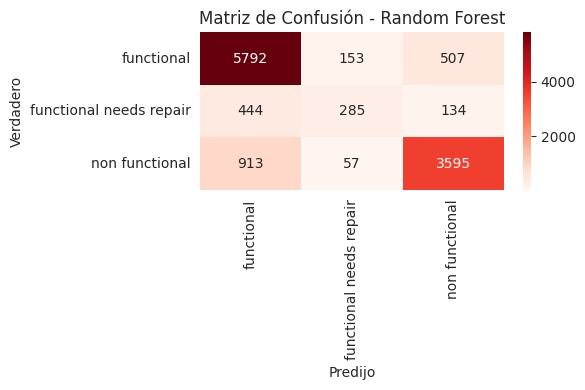

In [69]:
# 3. Genero una visualización gráfica de la matriz de confusión, que permite analizar cómo de bien (o mal) predice cada clase.
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - Random Forest")
plt.tight_layout()
plt.show()

### Conclusión de la Matriz de cofusión.
Indica que el modelo tiene un buen rendimiento en general, pero tiende a confundir la clase intermedia "functional needs repair" con las clases mayoritarias, especialmente "functional". Esto es un claro síntoma de desbalance de clases.

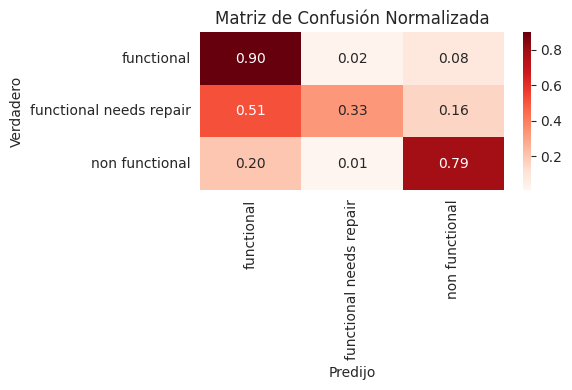

In [70]:
# 4. Genero una matriz de confusión normalizada, que muestra los errores y aciertos del modelo en forma de proporciones (porcentajes).
conf_matrix_norm = confusion_matrix(y_test, y_pred_rf, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión Normalizada")
plt.tight_layout()
plt.show()

## Interpretar la importancia de las variables.

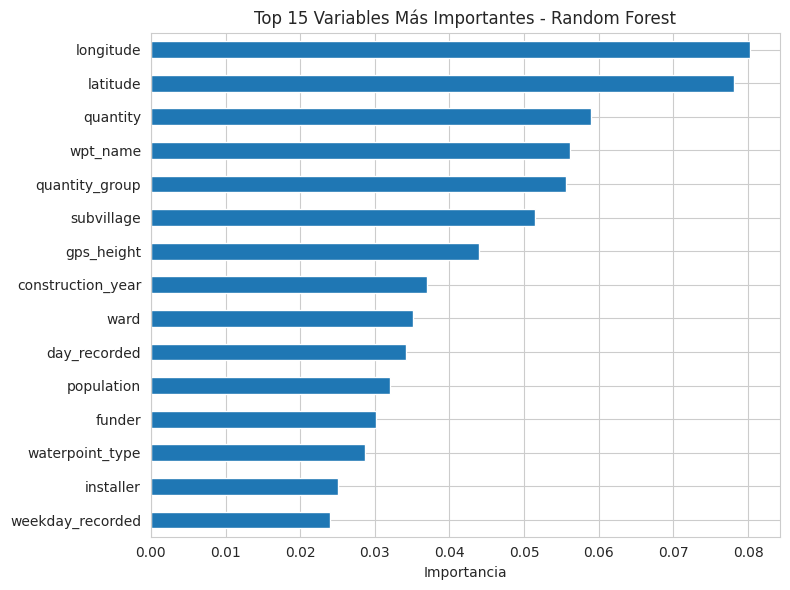

In [71]:
# Muestro las 15 variables más importantes que el modelo, para interpretar el modelo - feature engineering.
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 Variables Más Importantes - Random Forest")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### El modelo Random Forest está altamente influenciado por la ubicación geográfica y la cantidad de agua disponible, lo que refuerza la importancia de variables físicas y contextuales en la predicción del estado funcional de los pozos.

## Generación del archivo de predicciones (submission.csv) para el concurso.

In [72]:
# Genero el archivo final de predicciones (submission) para subirlo a la plataforma DrivenData.
X_submission_rf = test_values.drop(columns=['id'], errors='ignore')
# Elimino la columna 'id' del dataset de test, ya que no se utiliza como feature.
# Uso errors='ignore' para evitar error si 'id' no está presente.
X_submission_rf = X_submission_rf[X_train.columns]
# Aseguro que las columnas del test estén en el mismo orden y cantidad que en el entrenamiento.
y_submission_pred_rf = rf_model.predict(X_submission_rf)
# Realizo la predicción con el modelo Random Forest, sobre el conjunto de test.
y_submission_pred_labels_rf = le.inverse_transform(y_submission_pred_rf)
# Convierto las predicciones numéricas (0, 1, 2) a las etiquetas originales ('functional', etc.) usando el LabelEncoder entrenado previamente.
submission_rf = pd.DataFrame({
    'id': test_values['id'],
    'status_group': y_submission_pred_labels_rf
})
# Creo un nuevo DataFrame con las dos columnas requeridas para el submission:
# - 'id': el identificador original del punto de agua.
# - 'status_group': la clase predicha por el modelo.
submission_rf.to_csv('submission_rf.csv', index=False)
# Guardo el archivo como submission_rf.csv, sin incluir la columna de índice.
files.download('submission_rf.csv')
# Descargo automáticamente el archivo en el ordenador local del usuario.
submission_rf.head()
# Muestro por pantalla las primeras filas del archivo generado.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Modelado con LightGBM

In [73]:
# 1. Entreno un modelo de LightGBM y realizo predicciones sobre el conjunto de validación.
# LightGBM es un algoritmo de aprendizaje automático muy eficiente basado en árboles de decisión, especialmente diseñado para rendimiento y velocidad.
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000, # Crea 1000 árboles (bosque más grande = mejor precisión, pero más lento).
    learning_rate=0.05, # Cuánto aprende cada árbol. Valor bajo = aprendizaje más lento pero más preciso.
    max_depth=-1, # Sin límite de profundidad en los árboles. Deja que el algoritmo decida.
    random_state=42, # Asegura reproducibilidad
    n_jobs=-1 # Usa todos los núcleos del procesador para entrenar más rápido.
)

lgb_model.fit(X_train, y_train) # entrena el modelo.
y_pred_lgb = lgb_model.predict(X_test) # hago predicciones sobre los datos de prueba.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2886
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 41
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493


In [74]:
# 2. Avaluo el rendimiento del modelo LightGBM, usando métricas estándar de clasificación.
print("LightGBM - Accuracy:", accuracy_score(y_test, y_pred_lgb)) # Muestra el Accuracy (exactitud) del modelo.
print("\nLightGBM - Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=le.classes_))
# Saca por pantalla un reporte detallado que incluye:
# Precision: qué proporción de las predicciones positivas fueron realmente positivas.
# Recall: qué proporción de los positivos reales fueron correctamente identificados.
# F1-score:	media armónica entre precision y recall (equilibrio entre ambas).
# Support: cantidad de muestras reales de cada clase.

LightGBM - Accuracy: 0.8066498316498316

LightGBM - Classification Report:
                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      6452
functional needs repair       0.60      0.29      0.39       863
         non functional       0.85      0.76      0.80      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



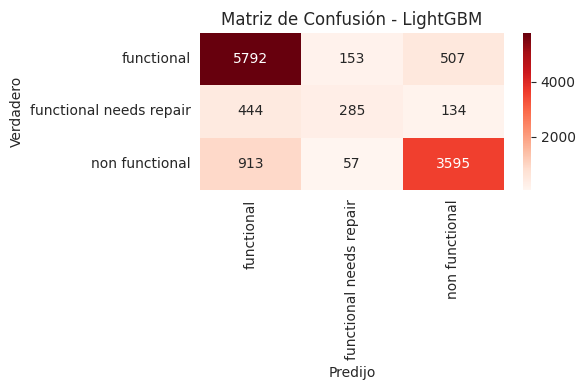

In [75]:
# 3. Genero una visualización gráfica de la matriz de confusión, que permite analizar cómo de bien (o mal) predice cada clase.
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - LightGBM")
plt.tight_layout()
plt.show()

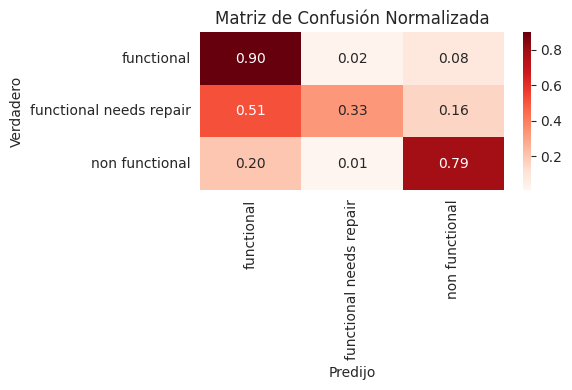

In [76]:
# 4. Genero una matriz de confusión normalizada, que muestra los errores y aciertos del modelo en forma de proporciones (porcentajes).
conf_matrix_norm = confusion_matrix(y_test, y_pred_rf, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión Normalizada")
plt.tight_layout()
plt.show()

## Interpretar la importancia de las variables.

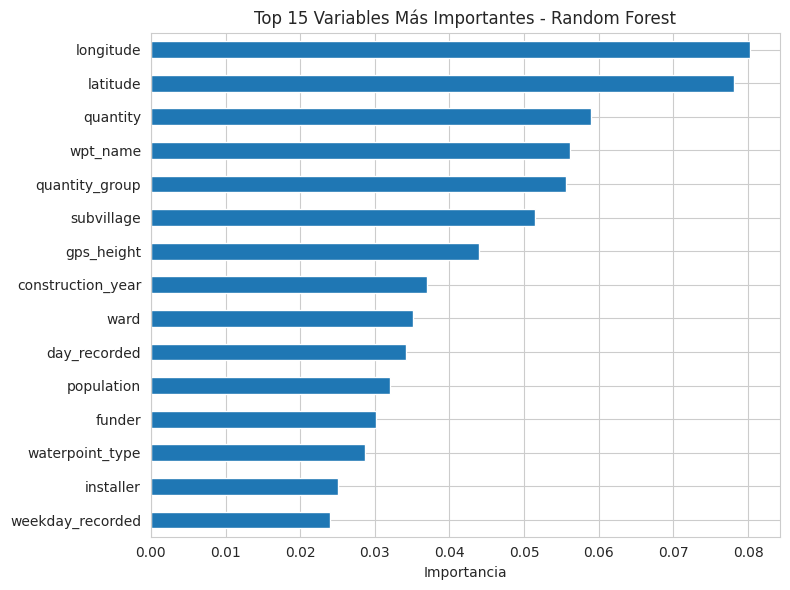

In [77]:
# Muestro las 15 variables más importantes que el modelo, para interpretar el modelo - feature engineering
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 Variables Más Importantes - Random Forest")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Generación del archivo de predicciones (submission.csv) para el concurso.

In [78]:
X_submission_lgb = test_values.drop(columns=['id'], errors='ignore')
X_submission_lgb = X_submission_lgb[X_train.columns]  # aseguro el mismo orden de columnas.

y_submission_pred_lgb = lgb_model.predict(X_submission_lgb)
y_submission_pred_labels_lgb = le.inverse_transform(y_submission_pred_lgb)

# Creo el archivo de submission
submission_lgb = pd.DataFrame({
    'id': test_values['id'],
    'status_group': y_submission_pred_labels_lgb
})

submission_lgb.to_csv('submission_lgb.csv', index=False)

# Descargar automáticamente
files.download('submission_lgb.csv')

# Mostrar primeras filas
submission_lgb.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Modelado con XGBoost

In [79]:
# 1. Entreno un modelo XGBoost y realizo predicciones sobre el conjunto de validación.
# XGBoost, es un algoritmos potente para tareas de clasificación supervisada.
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Inda que es máss rápido.
)

xgb_model.fit(X_train, y_train)
# Entreno el modelo con los datos de entrenamiento (X_train, y_train).
y_pred_xgb = xgb_model.predict(X_test)
# # hago predicciones sobre los datos de prueba.

In [80]:
# 2. Avaluo el rendimiento del modelo XGBoost, usando métricas estándar de clasificación.
print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred_xgb)) # Muestra el Accuracy (exactitud) del modelo.
print("\nXGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
# Saca por pantalla un reporte detallado que incluye:
# Precision: qué proporción de las predicciones positivas fueron realmente positivas.
# Recall: qué proporción de los positivos reales fueron correctamente identificados.
# F1-score:	media armónica entre precision y recall (equilibrio entre ambas).
# Support: cantidad de muestras reales de cada clase.

XGBoost - Accuracy: 0.8090909090909091

XGBoost - Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.55      0.30      0.39       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



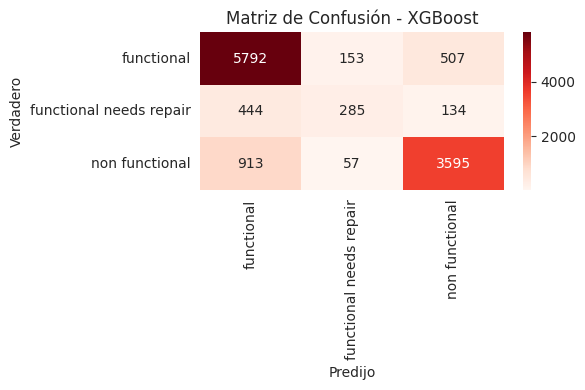

In [81]:
# 3. Genero una visualización gráfica de la matriz de confusión, que permite analizar cómo de bien (o mal) predice cada clase.
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - XGBoost")
plt.tight_layout()
plt.show()

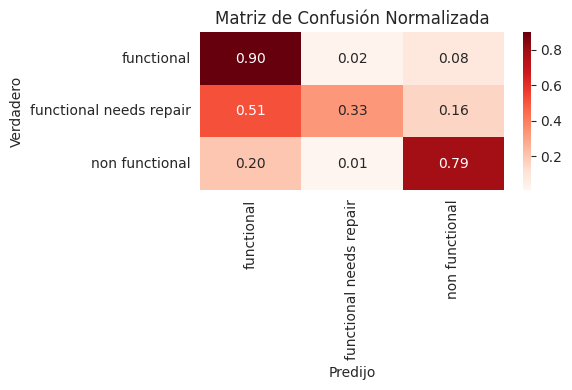

In [82]:
# 4. Genero una matriz de confusión normalizada, que muestra los errores y aciertos del modelo en forma de proporciones (porcentajes).
conf_matrix_norm = confusion_matrix(y_test, y_pred_rf, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predijo")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión Normalizada")
plt.tight_layout()
plt.show()

## Interpretar la importancia de las variables.

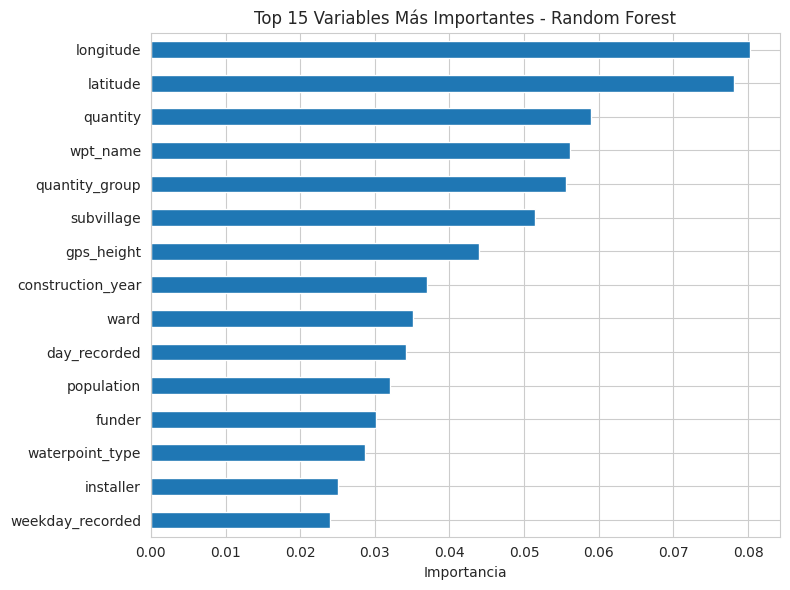

In [83]:
# Muestro las 15 variables más importantes que el modelo, para interpretar el modelo - feature engineering
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 Variables Más Importantes - Random Forest")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Generación del archivo de predicciones (submission.csv) para el concurso.

In [84]:
X_submission_xgb = test_values.drop(columns=['id'], errors='ignore')
X_submission_xgb = X_submission_xgb[X_train.columns]  # Asegurar columnas iguales

y_submission_pred_xgb = xgb_model.predict(X_submission_xgb)
y_submission_pred_labels_xgb = le.inverse_transform(y_submission_pred_xgb)

# Creo el archivo de submission
submission_xgb = pd.DataFrame({
    'id': test_values['id'],
    'status_group': y_submission_pred_labels_xgb
})

submission_xgb.to_csv('submission_xgb.csv', index=False)

# Se descarga automáticamente el archivo, en el ordenador.
files.download('submission_xgb.csv')

# Mostro las primeras filas
submission_xgb.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


# LAS CONCLUSIONES FINALES - DE LA PRÁCTICA DE AVALUACIÓN ML
# LAS HE SUBIDO A LA PLATAFORMA, COMO UN ARCHIVO PDF